In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
import cx_Oracle
import matplotlib.pyplot as plt
import time 
import os
import pickle

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Pay1 Value Add")
seed = 5

# Read Data

In [2]:
# # @in the password is causing errror in using the below syntax
# # connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# connection = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# cursor = connection.cursor()

# query= """
# with base as
# (
# select a.skp_credit_case,c.TIME_DECISION_DATE date_decision,credit_score,RISK_FPD30, RISK_FSPD30, RISK_FSTPD30, RISK_FSTQPD30, RISK_FSTQPD60,
# GENERALMODELLGBM, GENERALMODELLOGREG, 
# case when credit_score is null then 0
# when credit_score < 0.02158 then 0.5066
# when credit_score < 0.06401 then -0.0457
# when credit_score >= 0.0641 then -0.5516
# else 0 end as credit_score_woe
# from 
# (select skp_credit_case, credit_score - floor(credit_score) as credit_score from
# bd_vil 
# )a 
# join  AP_UWI.AK_POS_EXI_RESCORED b 
# on a.skp_credit_case = b.skp_credit_case
# join uw_daily_data_all c
# on a.skp_credit_case = c.skp_credit_case
# where time_decision_date >= to_date('01-08-19','dd-mm-yy')
# and product_group = 'CD'
# and client_exi_3m = 'Y'
# ),

# base1 as 
# (
# -------Rejected Base-----
# select skp_credit_case, GENERALMODELLGBM, credit_score as voda_score, credit_score_woe as voda_score_woe, 
# (ln(GENERALMODELLOGREG/(1-GENERALMODELLOGREG)) - 1*credit_score_woe) as combined_gm_lr_linear,
# 1/(1+exp(-1*(ln(GENERALMODELLOGREG/(1-GENERALMODELLOGREG)) - 1*credit_score_woe))) as combined_gm_lr,

# (ln(GENERALMODELLGBM/(1-GENERALMODELLGBM)) - 1*credit_score_woe) as combined_gm_lgbm_linear,
# 1/(1+exp(-1*(ln(GENERALMODELLGBM/(1-GENERALMODELLGBM)) - 1*credit_score_woe))) as combined_gm_lgbm

# from base
# union all

# --------Approved Base------
# select SKP_CREDIT_CASE,
# GENERALMODELLG,
# VODA_SCORE,
# VODA_SCORE_WOE,
# COMBINED_GM_LINEAR COMBINED_GM_LR_LINEAR,
# COMBINED_GM COMBINED_GM_LR,
# (ln(GENERALMODELLG/(1-GENERALMODELLG)) - 1*VODA_SCORE_WOE) as combined_gm_lgbm_linear,
# 1/(1+exp(-1*(ln(GENERALMODELLG/(1-GENERALMODELLG)) - 1*VODA_SCORE_WOE))) as combined_gm_lgbm
# from AP_UWI.AK_COMBINED_VODA_GM
# ), 

# uw_base as 
# (
# select a.skp_credit_case, time_decision_date, client_exi_3m, product_group, risk_fpd30, risk_agrf30, risk_fstqpd30, risk_agrf120, 
# risk_fstqpd60, risk_agrf150, pos_type,
# case when 
# client_exi_3m = 'N' then SCORE_APSC_NOV18 else 
#   case when POS_MAR20_GM_EXI is null then combined_gm_lgbm else POS_MAR20_GM_EXI end end  as RISK_SCORE
# from uw_daily_data_all a
# left join 
# (select skp_credit_case, combined_gm_lgbm from base1) b
# on a.skp_credit_case = b.skp_credit_case
# where time_decision_date >= to_date('18-06-20','dd-mm-yy')
# and product_group = 'CD'
# and decision_overall = 'Approved'
# ),

# bd_source_base as 
# (
# select skp_credit_case, result, 1 as score1 from bd_vmm
# where date_decision >= to_date('18-06-20','dd-mm-yy')
# )

# select a.skp_credit_case, time_decision_date, client_exi_3m, risk_fpd30, risk_agrf30, risk_fstqpd30, risk_agrf120, 
# risk_fstqpd60, risk_agrf150, case when result = 'FOUND' then 'FOUND' else 'NOT_FOUND' end as result, pos_type, score1, RISK_SCORE
# from 
# uw_base a 
# join bd_source_base b 
# on a.skp_credit_case = b.skp_credit_case
# where risk_score is not null
# and result in ('FOUND','NOT_FOUND')
# order by skp_credit_case
# """

# df = pd.read_sql(query,connection)

# df.to_pickle(os.getcwd()+r"\Data Files\loan_performance_dump.pkl")

In [3]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\loan_performance_dump.pkl")
# df = pd.read_csv(os.getcwd()+r"\Data Files\loan_performance_dump_v1.csv")


# Define Key Variables

In [4]:
time_decision_date = 'TIME_DECISION_DATE'
source = 'VMM'
target_variable = "RISK_FSTQPD30"
agrf_flag = "RISK_AGRF120"
fnf_flag = 'RESULT'
score = ['SCORE1']
risk_score = 'RISK_SCORE'

# Data Cleaning

In [5]:
#One Hot Encoding of fnf_flag
dummy = pd.get_dummies(df[fnf_flag])
dummy.columns = [y+"_"+fnf_flag for y in dummy.columns]
df = pd.concat([df, dummy], axis=1)

In [6]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CLIENT_EXI_3M,RISK_FPD30,RISK_AGRF30,RISK_FSTQPD30,RISK_AGRF120,RISK_FSTQPD60,RISK_AGRF150,RESULT,POS_TYPE,SCORE1,RISK_SCORE,FOUND_RESULT,NOT_FOUND_RESULT
0,308092015,2020-06-18,N,0,1,0,1,0,1,NOT_FOUND,AP,1,0.003505,0,1
1,308115426,2020-06-18,Y,0,1,0,1,0,1,FOUND,AP,1,0.098454,1,0
2,308141725,2020-06-18,Y,0,1,0,1,0,1,NOT_FOUND,Satellite,1,0.015603,0,1
3,308195350,2020-06-19,N,0,1,0,1,0,1,NOT_FOUND,Satellite,1,0.005864,0,1
4,308204068,2020-06-20,Y,0,1,0,1,0,1,NOT_FOUND,AP,1,0.038222,0,1


In [7]:
df.TIME_DECISION_DATE = pd.to_datetime(df.TIME_DECISION_DATE,format = '%d-%m-%y')
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [8]:
df = df[df.CLIENT_EXI_3M == 'N']

In [9]:
df = df[df[agrf_flag]==1]

<AxesSubplot:>

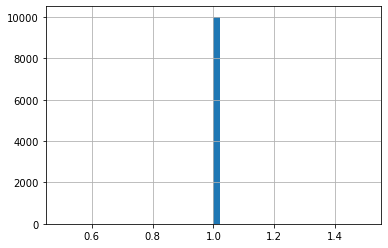

In [10]:
df[df["RESULT"]=="FOUND"]["SCORE1"].hist(bins = 50)

In [11]:
2*roc_auc_score(df["RISK_FPD30"],df["RISK_SCORE"])-1

0.13706720915350212

# MOM Plot of delinquency

In [12]:
df_agg=df[["MONTH_STR",target_variable]].groupby(["MONTH_STR"]).agg(["count","sum"])
df_agg.columns = ['_'.join(x) for x in df_agg.columns]
df_agg["BAD_RATE"] = df_agg[target_variable+"_sum"]/df_agg[target_variable+"_count"]

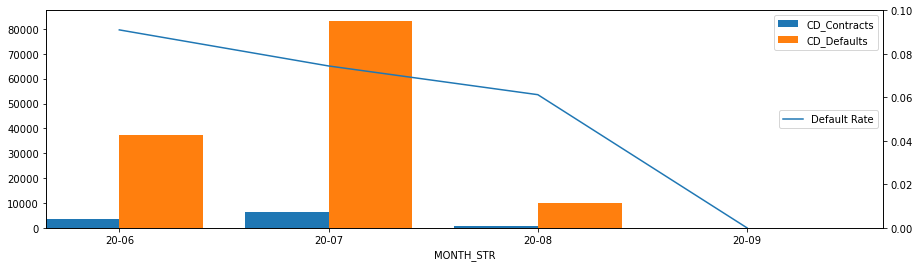

In [14]:
df_agg[[target_variable+"_sum",target_variable+"_count"]].plot(kind='bar', width = 0.8, figsize=(15,4))
df_agg['BAD_RATE'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_agg[target_variable+"_sum"])-0.35])
ax.set_xticklabels(df_agg.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.1)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")
plt.show()

# Define Key Variables

In [15]:
train_start = pd.datetime(2020,6,1)
train_end = pd.datetime(2020,6,30)
test_start = pd.datetime(2020,7,1)
test_end = pd.datetime(2020,8,31)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The

# Logistic Model- FNF Only

In [16]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)- np.log(1 -p)

## Test Train Split

In [17]:
for x in ["SCORE1","RISK_SCORE"]:
    df["LOG_"+x] = logit(df[x])
    df["LOG_"+x] = df["LOG_"+x].fillna(value = 0)

x_columns=['FOUND_RESULT','LOG_RISK_SCORE']
y_column = target_variable 

X_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)]
y_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)][y_column]

X_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)]
y_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)][y_column]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size = 0.7, random_state = seed)

##event rate
print("Event rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("Train set shape:",X_train.shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("Test set shape:",X_test.shape)
print("Event rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("validation set shape:",X_valid.shape)
print("Train GINI",  roc_auc_score(y_train, X_train[risk_score])*2 -1)
print("Test GINI",  roc_auc_score(y_test, X_test[risk_score])*2 -1)
print("validation GINI",  roc_auc_score(y_valid, X_valid[risk_score])*2 -1)

Event rate in train set : 9.47%
Train set shape: (11197, 18)
Event rate in test set : 7.31%
Test set shape: (93169, 18)
Event rate in validation set : 8.95%
validation set shape: (26129, 18)
Train GINI 0.1373164998017724
Test GINI 0.1278495914404938
validation GINI 0.12453880245075855


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## L1 Penalty Hyper Parameter Optimization

In [22]:
param_grid = {'C':np.exp(np.arange(-3,6,0.01))}

In [23]:
kfolds = StratifiedKFold(3, random_state=1, shuffle = True)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 40,
    cv=kfolds.split(X_train[x_columns],y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [24]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[x_columns], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\

Randomized search time: 5.190107107162476


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 311.0644109813349}


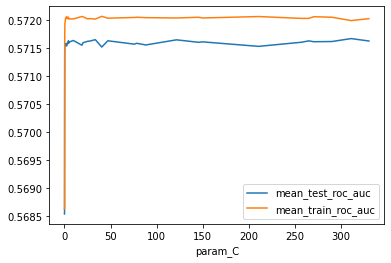

In [25]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

## Logistic With optimized Hyperparameters 

In [26]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'], solver='liblinear')

bst.fit(X_train[x_columns], y_train)

ypred_train = bst.predict_proba(X_train[x_columns])[:, 1]
ypred_valid = bst.predict_proba(X_valid[x_columns])[:, 1]
ypred_test = bst.predict_proba(X_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_test, ypred_test)-1))

print("Train GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_train, X_train[risk_score])-1))
print("Valid GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_valid, X_valid[risk_score])-1))
print("Test GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_test, X_test[risk_score])-1))


Train GINI(COMBINED_SCORE) 0.144
Valid GINI(COMBINED_SCORE) 0.130
Test GINI(COMBINED_SCORE) 0.138
Train GINI(RISK_SCORE) 0.137
Valid GINI(RISK_SCORE) 0.125
Test GINI(RISK_SCORE) 0.128


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,FOUND_RESULT,-0.343866
1,LOG_RISK_SCORE,0.460450


In [28]:
df["COMBINED_SCORE_ONLY_FNF_FLAG"] =  bst.predict_proba(df[x_columns])[:, 1]

## Model Evaluation

In [29]:
combined_score_only_fnf_flag = "COMBINED_SCORE_ONLY_FNF_FLAG"

### Gini Chart

In [30]:
print("GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(df[target_variable], df[combined_score_only_fnf_flag])-1))

GINI(RISK_SCORE) 0.137


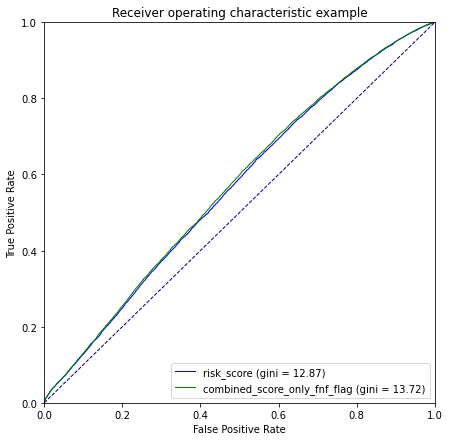

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df[target_variable],df[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='risk_score (gini = %0.2f)' % ((2*roc_auc-1)*100))



fpr, tpr, thresholds = roc_curve(df[target_variable],df[combined_score_only_fnf_flag])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='combined_score_only_fnf_flag (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [32]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CLIENT_EXI_3M,RISK_FPD30,RISK_AGRF30,RISK_FSTQPD30,RISK_AGRF120,RISK_FSTQPD60,RISK_AGRF150,RESULT,POS_TYPE,SCORE1,RISK_SCORE,FOUND_RESULT,NOT_FOUND_RESULT,MONTH_STR,LOG_SCORE1,LOG_RISK_SCORE,COMBINED_SCORE_ONLY_FNF_FLAG
0,308092015,2020-06-18,N,0,1,0,1,0,1,NOT_FOUND,AP,1,0.003505,0,1,20-06,inf,-5.650120,0.075307
3,308195350,2020-06-19,N,0,1,0,1,0,1,NOT_FOUND,Satellite,1,0.005864,0,1,20-06,inf,-5.133048,0.093655
5,308204155,2020-06-18,N,0,1,0,1,0,1,NOT_FOUND,AP,1,0.007225,0,1,20-06,inf,-4.922989,0.102194
8,308204314,2020-06-18,N,0,1,0,1,0,1,NOT_FOUND,AP,1,0.003390,0,1,20-06,inf,-5.683383,0.074248
11,308211026,2020-06-18,N,0,1,0,1,0,1,NOT_FOUND,AP,1,0.004513,0,1,20-06,inf,-5.396178,0.083865


In [33]:
gini_dic = {}
predictor_list = ["FOUND_RESULT"]
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if combined_score_only_fnf_flag not in gini_dic: 
            gini_dic[combined_score_only_fnf_flag] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[combined_score_only_fnf_flag].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][combined_score_only_fnf_flag])-1)*100)
        gini_dic["MONTH_STR"].append(x)
        for y in predictor_list:
            if y not in gini_dic:
                  gini_dic[y] = []
            if y != 'FOUND_RESULT':
                try:
                    gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
                except:
                    gini_dic[y].append(0)
            else:
                gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


Found Rate:  7.67%


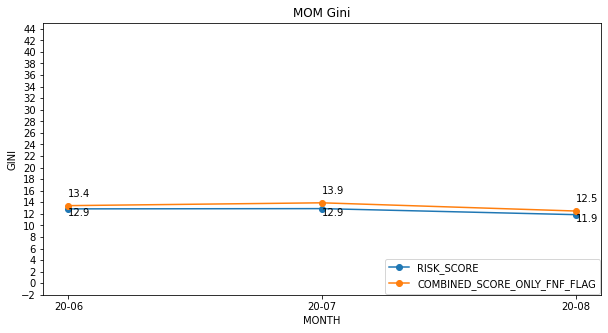

In [34]:
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(-2,45,2))
ax1.set_title("MOM Gini")
plt.show()


GINI of BD Source score is corresponding to found cases only!
Found Rate:  7.67%


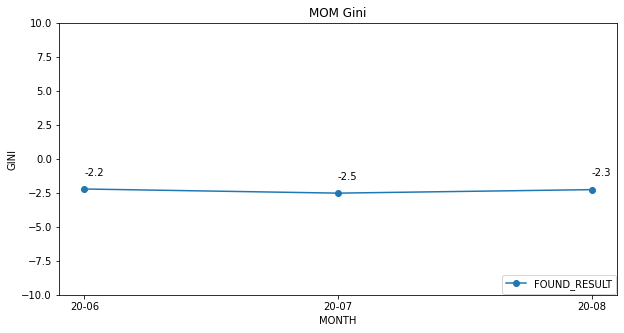

In [35]:
print("GINI of BD Source score is corresponding to found cases only!")
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score], marker='o', scaley = False, label = combined_score)
# ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
for y in predictor_list:
    ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


# for i, txt in enumerate(gini_df[combined_score]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score][i]+0.8))
# for i, txt in enumerate(gini_df[risk_score]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

for y in predictor_list:
    for i, txt in enumerate(gini_df[y]):
        plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-10,10)
plt.ylabel("GINI")
plt.xlabel("MONTH")
# plt.yticks(np.arange(-50,50,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [36]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [37]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped.agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped.agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped.agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped.agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [50]:
combined_score_only_fnf_flag_lift

,min_prob,max_prob,total,bads,goods,%base,cum%_base,%bads,%goods,cum%_bads,cum%_goods,lift,cum_lift
Decile,,,,,,,,,,,,,
1,0.114805,0.354694,13050,1302,11748,10.00%,10.00%,12.76%,9.77%,12.76%,1.08%,1.276,1.276
2,0.108903,0.114804,13050,1247,11803,10.00%,20.00%,12.22%,9.81%,24.97%,2.12%,1.222,1.249
3,0.103841,0.108901,13049,1223,11826,10.00%,30.00%,11.98%,9.83%,36.96%,3.14%,1.198,1.232
4,0.099083,0.103840,13050,1109,11941,10.00%,40.00%,10.87%,9.93%,47.82%,4.06%,1.086,1.195
5,0.094329,0.099083,13049,1144,11905,10.00%,50.00%,11.21%,9.90%,59.03%,5.01%,1.121,1.181
6,0.089321,0.094329,13050,1066,11984,10.00%,60.00%,10.44%,9.96%,69.47%,5.89%,1.044,1.158
7,0.083860,0.089321,13050,961,12089,10.00%,70.00%,9.42%,10.05%,78.89%,6.69%,0.941,1.127
8,0.077675,0.083860,13049,863,12186,10.00%,80.00%,8.45%,10.13%,87.34%,7.41%,0.846,1.092
9,0.069111,0.077675,13050,751,12299,10.00%,90.00%,7.36%,10.22%,94.70%,8.04%,0.736,1.052


In [38]:
#cum%_bads is gain_score
risk_score_lift = lift_and_gain_df(data=df,target=target_variable, prob=risk_score)
combined_score_only_fnf_flag_lift = lift_and_gain_df(data=df,target=target_variable, prob=combined_score_only_fnf_flag)

### Cumulative Lift Chart 

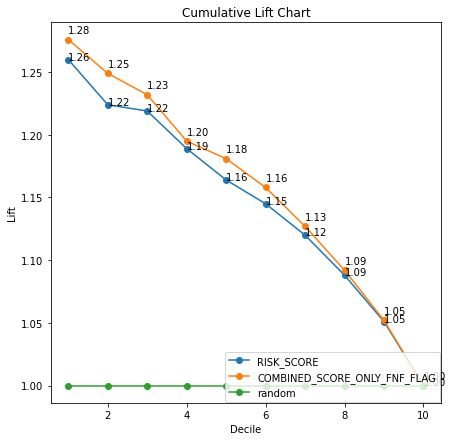

In [41]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = risk_score, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(combined_score_only_fnf_flag_lift.index,combined_score_only_fnf_flag_lift["cum_lift"], label = combined_score_only_fnf_flag, marker='o')
for i, txt in enumerate(combined_score_only_fnf_flag_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_only_fnf_flag_lift.index[i], combined_score_only_fnf_flag_lift["cum_lift"][i+1]+0.005))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


# MOM Gini: FPD30 Target

In [42]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\loan_performance_dump.pkl")

In [43]:
time_decision_date = 'TIME_DECISION_DATE'
source = 'VMM'
target_variable = "RISK_FPD30"
agrf_flag = "RISK_AGRF30"
fnf_flag = 'RESULT'
score = ['SCORE1']
risk_score = 'RISK_SCORE'

In [44]:
#One Hot Encoding of fnf_flag
dummy = pd.get_dummies(df[fnf_flag])
dummy.columns = [y+"_"+fnf_flag for y in dummy.columns]
df = pd.concat([df, dummy], axis=1)

In [45]:
df.TIME_DECISION_DATE = pd.to_datetime(df.TIME_DECISION_DATE,format = '%d-%m-%y')
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

df = df[df.CLIENT_EXI_3M == 'N']

df = df[df[agrf_flag]==1]

In [46]:
for x in ["SCORE1","RISK_SCORE"]:
    df["LOG_"+x] = logit(df[x])
    df["LOG_"+x] = df["LOG_"+x].fillna(value = 0)

x_columns=['FOUND_RESULT','LOG_RISK_SCORE']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
df["COMBINED_SCORE_ONLY_FNF_FLAG"] =  bst.predict_proba(df[x_columns])[:, 1]

In [48]:
gini_dic = {}
predictor_list = ["FOUND_RESULT"]
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if combined_score_only_fnf_flag not in gini_dic: 
            gini_dic[combined_score_only_fnf_flag] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[combined_score_only_fnf_flag].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][combined_score_only_fnf_flag])-1)*100)
        gini_dic["MONTH_STR"].append(x)
        for y in predictor_list:
            if y not in gini_dic:
                  gini_dic[y] = []
            if y != 'FOUND_RESULT':
                try:
                    gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
                except:
                    gini_dic[y].append(0)
            else:
                gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


Found Rate:  7.04%


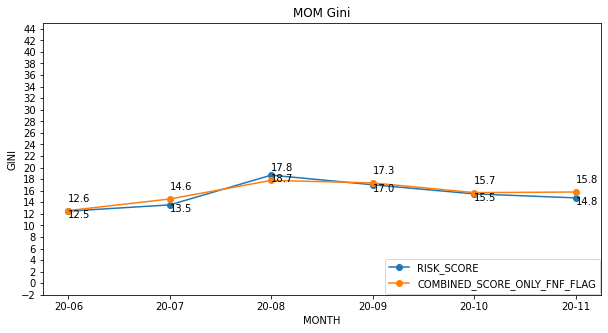

In [49]:
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(-2,45,2))
ax1.set_title("MOM Gini")
plt.show()
